# Proyecto Máquinas de Aprendizaje
## Predicción de Incendios Forestales utilizando técnicas de Máquinas de Aprendizaje
### Daniel San Martín

Este proyecto tiene como objetivo analizar el trabajo desarrollado en el artículo "**A Data Mining Approach to Predict Forest Fires using Meteorological Data**" de Paulo Cortez y Aníbal Morais. Para esto se realiza una comparación, análisis y propuesta de modelos sobre el trabajo desarrollado por los autores mencionados.

In [1]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data manipulation

# Models
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import AdaBoostRegressor as ABR, BaggingRegressor as BR, \
    ExtraTreesRegressor as ETR, GradientBoostingRegressor as GBR, RandomForestRegressor as RFR 
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.svm import SVR

# Tools 
from sklearn.preprocessing import MinMaxScaler, StandardScaler # data pre-processing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # tools
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib # to save models
from sklearn.utils import shuffle
import matplotlib.pyplot as plt # plots
import pandas.plotting as pdplt

import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

## Pre-procesamiento de datos

Los datos utilizados en este trabajo fueron extraidos del parque natural de Montesinho, en Trás-os-Montes región del noreste de Portugal, y contienen información sobre las áreas de terreno quemada en episodios de incendios entre enero del 2000 y diciembre del 2003.

In [2]:
# Load data
df = pd.read_csv("./data/forestfires.csv", sep = ",",header = 0)

# Categorize month and days
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

# Data information
print("Shape: ", df.shape)
df.info()
df.describe()

Shape:  (517, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null int64
day      517 non-null int64
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Notamos que el conjunto de datos posee un total de **517** registros con **12** atributos más la variable dependiente, en este caso el área quemada. Los datos contenidos corresponden a: 
1. Datos espaciales: mapeo del terreno a coordenadas $x$ e $y$.
* Datos temporales: día y mes del año.
* Datos del sistema FWI: códigos asociados al material y cantidad de combustible, además de un índice para evaluar la velocidad del fuego.
* Datos meteorológicos: temperatura (°C), humedad relativa (%), velocidad del viento (km/hr) y precipitaciones en (mm/m²).

El área, la variable dependiente, se encuentra expresada en hectáreas (ha).

<!--Además, los autores proponene 4 configuraciones de características para desarrollar los modelos:
1. **STFWI** utilizando los datos espaciales, temporales y FWI.
* **STM** utilizando los datos espaciales, temporales y meteorológicos.
* **FWI**  utilizando solo los datos de este sistema.
* **M** utilizando los datos meteorológicos.

A modo de comparación, se utilizarán de igual forma los datos "crudos".  Para mejorar la capacidad del modelo se utiliza la categorización utilizando la estrategia *1-of-C*.-->

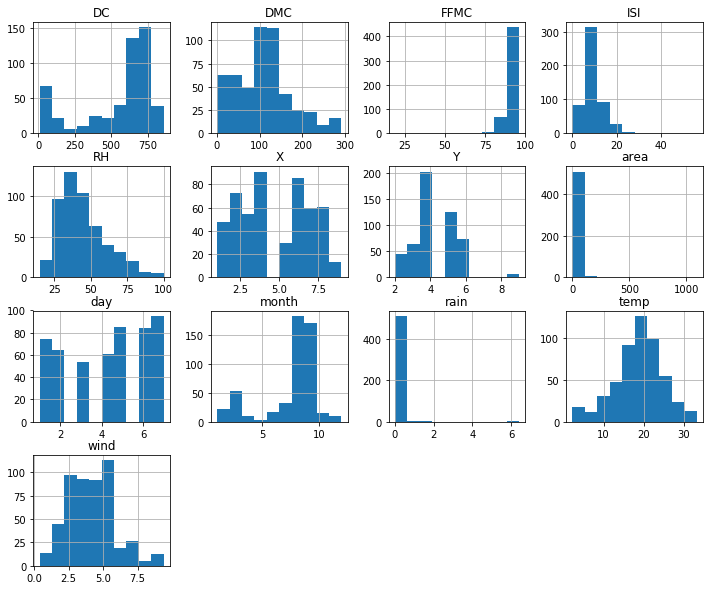

In [3]:
df.hist(figsize=(12, 10))
plt.show()

De los histogramas podemos notar que la variable independiente tiene muchos valores cercanos a $0$, en comparación a los otros, lo que podría dificultar la predicción de estos. Además, de la tabla anterior, podemos ver la diferencia de escala de estos valores que también podría influir considerablemente en el problema.

In [4]:
def plot_corr(df, size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr)
    plt.title("Correlation Matrix")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(mat)
    plt.show()

In [5]:
df.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


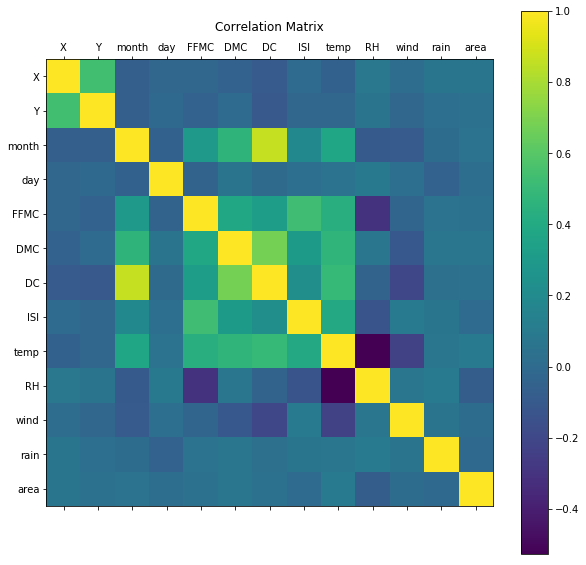

In [6]:
plot_corr(df)

Al analizar la correlación entre los datos podemos ver que existe una mayor relación entre los datos del sistema FWI y la temperatura. Esto tiene sentido dado que para calcularlos se utilza la temperatura como uno de los elementos de cálculo. Además, entre ellos también existe una relación considerable.

In [7]:
X = df.iloc[:,:-1]
y = df.loc[:,['area']]

In [8]:
# Split dataset 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [9]:
# Scaler 
scaler = StandardScaler().fit(X)

# Pre-processing data
X_train_sc = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

Del análisis realizado anteriormente notamos que existe mayor cantidad de incendios "pequeños", es por esto que se sugiere aplicar la transformación logarítmica $y=ln(x+1)$ para incluir un poco de simetría y además escalar los datos.

In [10]:
# Function to transform target
def transformTarget(y):
    # Min - max scaler
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Logarithmic target
    y_log = np.log(y + 1)
    
    y_scaler.fit(y_log)
    
    y_sc = y_scaler.transform(y_log)
    
    #y_sc = sy.fit_transform(y_log.as_matrix().reshape(len(y), 1)).flatten()
    
    return y_sc, y_scaler
    
# Function to compute the inverse transform
def inverseTransformTarget(y, scaler):
    y_log = scaler.inverse_transform(y)
    y = np.exp(y_log) - 1
    return y

In [11]:
y_sc, y_scaler = transformTarget(y)

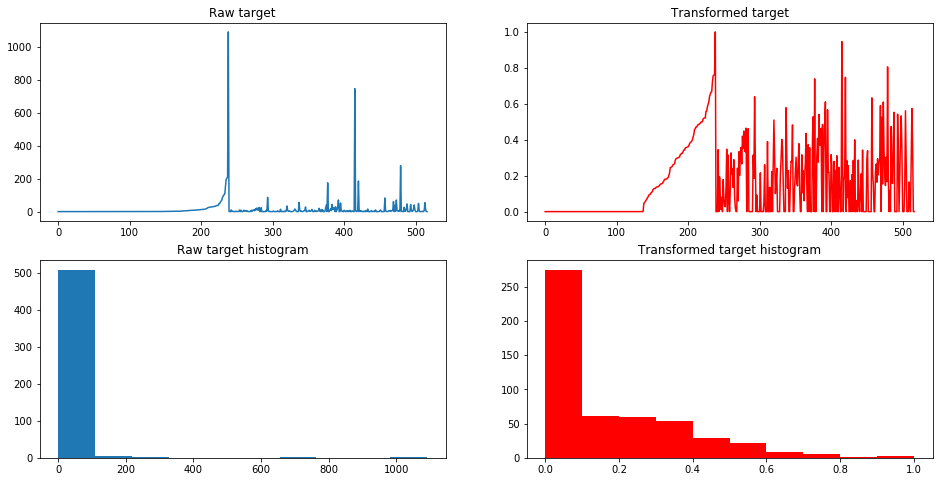

In [12]:
# Comparison plot
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y.values)
plt.title("Raw target")
plt.subplot(2, 2, 2)
plt.plot(y_sc, 'r')
plt.title("Transformed target")
plt.subplot(2, 2, 3)
plt.hist(y.values)
plt.title("Raw target histogram")
plt.subplot(2, 2, 4)
plt.hist(y_sc, color='red')
plt.title("Transformed target histogram")
plt.show()

Notamos la clara diferencia en el área una vez que aplicamos la transformación logaritmica.

Para evaluar la calidad de los modelos se utilizaran las méticas: $MAE$, $MSE$ y $RMSE$ para comparar los resultados del ariculo guía. 

In [14]:
def printScores(y_real, y_hat):
    #print("R2: %.4f" % r2_score(y_real, y_hat))
    print("MSE: %.4f" %  mean_squared_error(y_real, y_hat))
    print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_real, y_hat)))
    print("MAE: %.4f" % mean_absolute_error(y_real, y_hat))

In [15]:
def checkRFECV(model, dataset, target):
    sel = RFECV(model, step=1, cv=5, scoring='r2')
    sel = sel.fit(dataset, target)
    sel_pos = RFECVInfo(sel, plot=True)
    return sel_pos # Features selected

In [16]:
def RFECVInfo(selector, plot=False):
    print("Optimal number of features : %d" % selector.n_features_)
    print("Best score: %.4f" % np.max(selector.grid_scores_))

    if plot:
        # Plot number of features VS. cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score")
        plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
        plt.grid(True)
        plt.show()
    else:
        print("Scores: ", selector.grid_scores_) # Scores
        print("Rankings: ", selector.ranking_) # Ranking
        
    # Get positions of features
    pos = np.argwhere(selector.support_).T[0]
    return pos

In [17]:
def CVScores(model):
    scores = [
        #["Train R²: ", model.cv_results_['mean_train_r2'][model.best_index_]],
        ["Train MSE: ", abs(model.cv_results_['mean_train_neg_mean_squared_error'][model.best_index_])],
        ["Train MAE: ", abs(model.cv_results_['mean_train_neg_mean_absolute_error'][model.best_index_])],
        #["Validation R²: ", model.cv_results_['mean_test_r2'][model.best_index_]],
        ["Validation MSE: ", abs(model.cv_results_['mean_test_neg_mean_squared_error'][model.best_index_])],
        ["Validation MAE: ", abs(model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_])]
    ]
    return pd.DataFrame(scores, columns=['Metric', 'Score'])

In [18]:
# Combine all data and targets using GridSearchCV
def GSCVData(model, datasets, targets, parameters, scorers, cv, verbose=False):
    gs_models = []
    best_score = -np.inf
    bd, bt, bm, m = 0, 0, 0, 0
    
    # Grid search for every data-target combination
    for d in range(len(datasets)):
            
        for t in range(len(targets)):    
                
            #test_model = GridSearchCV(model, parameters, cv=cv, scoring=scorers, refit='r2', n_jobs=4)
            #test_model = GridSearchCV(model, parameters, cv=cv, scoring='neg_mean_squared_error', n_jobs=4)
            test_model = GridSearchCV(model, parameters, cv=cv, scoring=scorers, 
                                      refit='neg_mean_squared_error', n_jobs=4)
            _ = test_model.fit(datasets[d], targets[t])
                                                 
            if test_model.best_score_ > best_score:
                best_score = test_model.best_score_
                bd, bt, bm = d, t, m
                
            if verbose:
                print(data_labels[d] + ", " + target_labels[t])
                CVScores(test_model)
                print("")
                
            gs_models.append(test_model)
            m += 1
        
    print("Best model configuration:")
    #print("Data: %s" % data_labels[bd])
    #print("Target: %s" % target_labels[bt])
    print("Parameters: %s" % gs_models[bm].best_params_)
    print("Best Score: %.4f" % gs_models[bm].best_score_)
    print("")
                
    return gs_models, bd, bt, bm

In [21]:
# Fixed variables

# Data
#datasets = [STFWI_sc, STFWI1C_sc, STM_sc, STM1C_sc, FWI_sc, M_sc, X_sc, X1C_sc] # List of datasets tested
#targets = [y_sc, y_log, y_log_sc] # List of targets tested
datasets = [X_train_sc]#, shuffle(X_train_sc, random_state=0)]
targets = [y_sc]

# Labels for naming
#data_labels = ["STFWI", "STFWI 1C", "STM", "STM 1C", "FWI", "M", "X", "X 1C"]
#target_labels = ["Scaled", "Logarithmic", "Logarithmic scaled"]
data_labels = ["Normal"]#, "Shuffle 1"]
target_labels = ["Transformed"]

# Metric scorers
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']

# Number of K-folds for cross validation
cv_ = 5

## Linear Regression

In [22]:
def searchLR(model, datasets, targets, cv, verbose=False):
    scores = np.zeros((len(datasets), len(targets), 2))
    best_mse_score = -np.inf
    bd, bt = 0, 0

    for d in range(len(datasets)):
        for t in range(len(targets)):
            #r2 = cross_val_score(model, datasets[d], targets[t], 
            #                     cv=cv, scoring='r2', n_jobs=-1)
            mse = cross_val_score(model, datasets[d], targets[t], 
                                  cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
            mae = cross_val_score(model, datasets[d], targets[t], cv=cv, 
                                  scoring='neg_mean_absolute_error', n_jobs=-1)

            #scores[d, t, 0] = r2.mean()
            scores[d, t, 0] = mse.mean()
            scores[d, t, 1] = mae.mean()
            
            if scores[d, t, 0] > best_mse_score:
                best_mse_score = scores[d, t, 0]
                bd, bt = d, t

            if verbose:
                print("Best configuration:")
                #print("Data: %s" % data_labels[bd])
                #print("Target: %s" % target_labels[bt])
                #print("R2: %.4f" % scores[bd, bt, 0])
                print("MSE: %.4f" % abs(scores[bd, bt, 0]))
                print("MAE: %.4f" % abs(scores[bd, bt, 1]))    
                print("")
        
        print("Best configuration:")
        #print("Data: %s" % data_labels[bd])
        #print("Target: %s" % target_labels[bt])
        #print("R2: %.4f" % scores[bd, bt, 0])
        print("MSE: %.4f" % abs(scores[bd, bt, 0]))
        print("MAE: %.4f" % abs(scores[bd, bt, 1]))    
        print("")
        
        return scores, bd, bt

In [23]:
sc, lr_d , lr_t = searchLR(LR(), datasets, targets, cv_)

Best configuration:
MSE: 0.0551
MAE: 0.1878



Optimal number of features : 1
Best score: -0.1655


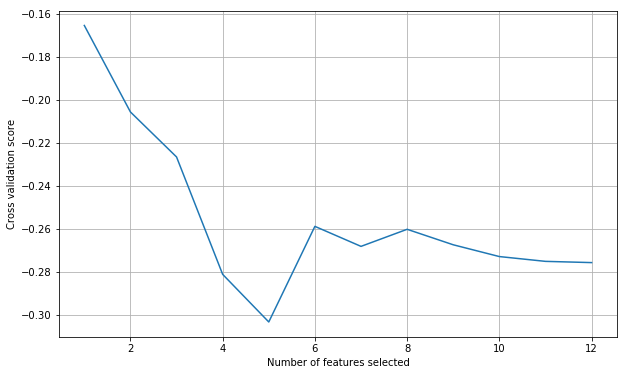

In [24]:
_ = checkRFECV(LR(), datasets[lr_d], targets[lr_t])

In [37]:
lr = LR()

In [38]:
lr.fit(X_train_sc, y_sc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
lr_y_pred = lr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(lr_y_pred.reshape(-1, 1), y_scaler))

MSE: 12069.9164
RMSE: 109.8632
MAE: 19.5794


## Decision Trees

In [40]:
dtr_parameters = {
    'criterion': ['mse', 'mae'],
    'splitter': ['best', 'random'], 
    'max_depth': [10, 50, 100]
}

In [41]:
dtr_models, dtr_d, dtr_t, dtr_m = GSCVData(DTR(), datasets, targets, dtr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'criterion': 'mae', 'max_depth': 10, 'splitter': 'best'}
Best Score: -0.0802



In [42]:
CVScores(dtr_models[dtr_m])

,Metric,Score
0,Train MSE:,0.026533
1,Train MAE:,0.076277
2,Validation MSE:,0.080247
3,Validation MAE:,0.212517


In [43]:
joblib.dump(dtr_models[dtr_m].best_estimator_, 'models/dt.pkl')

['models/dt.pkl']

In [46]:
dt = dtr_models[dtr_m].best_estimator_
dt_y_pred = dt.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(dt_y_pred.reshape(-1, 1), y_scaler))

MSE: 11575.8427
RMSE: 107.5911
MAE: 15.0174


## SVM

In [47]:
svr_parameters = [
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['linear']},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 
         'kernel': ['poly'], 'degree': [3, 4, 5], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
 ]

In [48]:
svr_models, svr_d, svr_t, svr_m = GSCVData(SVR(), datasets, targets, svr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'C': 1, 'degree': 5, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Best Score: -0.0461



In [49]:
CVScores(svr_models[svr_m])

,Metric,Score
0,Train MSE:,0.041764
1,Train MAE:,0.157116
2,Validation MSE:,0.046120
3,Validation MAE:,0.169270


In [ ]:
_ = checkRFECV(dtr_models[svr_m].best_estimator_, datasets[svr_d], targets[svr_t])

In [50]:
joblib.dump(svr_models[svr_m].best_estimator_, 'models/svm.pkl')

['models/svm.pkl']

In [51]:
svr = svr_models[svr_m].best_estimator_
svr_y_pred = svr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(svr_y_pred.reshape(-1, 1), y_scaler))

MSE: 12135.2504
RMSE: 110.1601
MAE: 19.6729


## Neural Network

In [52]:
nnr_parameters = {
    'hidden_layer_sizes': [(5, ), (10, ), (20, )], 
    'activation':  ['identity', 'logistic', 'relu'] ,
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1],
    'batch_size': [50, 100, 200],
}

In [53]:
nnr_models, nnr_d, nnr_t, nnr_m = GSCVData(MLPR(random_state=seed), datasets, targets, nnr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 50, 'hidden_layer_sizes': (20,), 'solver': 'adam'}
Best Score: -0.0457



In [54]:
CVScores(nnr_models[nnr_m])

,Metric,Score
0,Train MSE:,0.037896
1,Train MAE:,0.158520
2,Validation MSE:,0.045662
3,Validation MAE:,0.177106


In [55]:
joblib.dump(nnr_models[nnr_m].best_estimator_, 'models/mlp.pkl')

['models/mlp.pkl']

In [56]:
nnr = nnr_models[nnr_m].best_estimator_
nnr_y_pred = nnr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(nnr_y_pred.reshape(-1, 1), y_scaler))

MSE: 12079.3711
RMSE: 109.9062
MAE: 19.6552


## Bagging

In [57]:
bgr_parameters = {
    'n_estimators': [50, 100, 200], 
}

In [58]:
bgr_models, bgr_d, bgr_t, bgr_m = GSCVData(BR(random_state=seed, n_jobs=-1), datasets, targets, 
                                           bgr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'n_estimators': 50}
Best Score: -0.0603



In [59]:
CVScores(bgr_models[bgr_m])

,Metric,Score
0,Train MSE:,0.006518
1,Train MAE:,0.063305
2,Validation MSE:,0.060268
3,Validation MAE:,0.203382


In [61]:
joblib.dump(bgr_models[bgr_m].best_estimator_, 'models/bagg.pkl')

['models/bagg.pkl']

In [60]:
bgr = bgr_models[bgr_m].best_estimator_
bgr_y_pred = bgr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(bgr_y_pred.reshape(-1, 1), y_scaler))

MSE: 8978.2424
RMSE: 94.7536
MAE: 14.3763


## Random Forest

In [62]:
rfr_parameters = {
    'n_estimators': [10, 20, 30], 
    'criterion': ['mse', 'mae'], 
    'max_depth': [50, 100]
}

In [63]:
rfr_models, rfr_d, rfr_t, rfr_m = GSCVData(RFR(random_state=seed, n_jobs=-1), 
                                           datasets, targets, rfr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'criterion': 'mae', 'max_depth': 50, 'n_estimators': 30}
Best Score: -0.0584



In [64]:
CVScores(rfr_models[rfr_m])

,Metric,Score
0,Train MSE:,0.008026
1,Train MAE:,0.068680
2,Validation MSE:,0.058435
3,Validation MAE:,0.199943


In [65]:
rfr = rfr_models[rfr_m].best_estimator_
rfr_y_pred = rfr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(rfr_y_pred.reshape(-1, 1), y_scaler))

MSE: 10293.9710
RMSE: 101.4592
MAE: 15.2504


In [ ]:
_ = checkRFECV(rfr_models[rfr_m].best_estimator_, datasets[rfr_d], targets[rfr_t])

In [66]:
joblib.dump(rfr_models[rfr_m].best_estimator_, 'models/rf.pkl')

['models/rf.pkl']

## Extremely Randomized Trees

In [67]:
etr_parameters = {
    'n_estimators': [50, 100, 200], 
    'criterion': ["mse", "mae"],
    'max_features': ["auto", "sqrt", "log2", None],
    'max_depth': [10, 50, 100]
}

In [68]:
etr_models, etr_d, etr_t, etr_m = GSCVData(ETR(random_state=seed, n_jobs=-1), datasets, targets, 
                                           etr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Best Score: -0.0523



In [69]:
CVScores(etr_models[etr_m])

,Metric,Score
0,Train MSE:,0.015795
1,Train MAE:,0.098231
2,Validation MSE:,0.052315
3,Validation MAE:,0.188978


In [70]:
joblib.dump(etr_models[etr_m].best_estimator_, 'models/etr.pkl')

['models/etr.pkl']

In [71]:
etr = etr_models[etr_m].best_estimator_
etr_y_pred = etr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(etr_y_pred.reshape(-1, 1), y_scaler))

MSE: 11764.2572
RMSE: 108.4632
MAE: 18.0386


## Adaboost

In [72]:
abr_parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'loss': ['linear', 'square', 'exponential'],
}

In [73]:
abr_models, abr_d, abr_t, abr_m = GSCVData(ABR(random_state=seed), datasets, targets, abr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Best Score: -0.0496



In [74]:
CVScores(abr_models[abr_m])

,Metric,Score
0,Train MSE:,0.032967
1,Train MAE:,0.154462
2,Validation MSE:,0.049644
3,Validation MAE:,0.186854


In [75]:
joblib.dump(abr_models[abr_m].best_estimator_, 'models/abr.pkl')

['models/abr.pkl']

In [76]:
abr = abr_models[abr_m].best_estimator_
abr_y_pred = abr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(abr_y_pred.reshape(-1, 1), y_scaler))

MSE: 11957.4573
RMSE: 109.3502
MAE: 19.6501


## Gradient Tree Boosting

In [77]:
gbr_parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate' : [0.1, 0.5, 1],
    'loss': ['ls', 'lad', 'huber'],
    'max_depth': [10, 20, 30],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

In [78]:
gbr_models, gbr_d, gbr_t, gbr_m = GSCVData(GBR(random_state=seed), datasets, targets, gbr_parameters, scorers, cv_)

Best model configuration:
Parameters: {'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 30, 'n_estimators': 50}
Best Score: -0.0608



In [79]:
CVScores(gbr_models[gbr_m])

,Metric,Score
0,Train MSE:,0.001333
1,Train MAE:,0.010600
2,Validation MSE:,0.060808
3,Validation MAE:,0.199098


In [80]:
joblib.dump(gbr_models[gbr_m].best_estimator_, 'models/gbr.pkl')

['models/gbr.pkl']

In [81]:
gbr = gbr_models[gbr_m].best_estimator_
gbr_y_pred = gbr.predict(X_test_sc)
printScores(y_test, inverseTransformTarget(gbr_y_pred.reshape(-1, 1), y_scaler))

MSE: 4255.8656
RMSE: 65.2370
MAE: 8.1275


## Conclusiones

Del desarrollo de este proyecto notamos la potencia de los modelos ensamblados, los cuales
mejoran los resultados considerablemente en comparación a los modelos no ensamblados. Si bien,
la publicación guía sugiere el uso de ciertas configuraciones de $X$, que podría ser vistos como
una selección de características, el modelo *GBT* demostró mejorar los resultados utilizando 
toda la información.

Por limitaciones computacionales no se realizaron más pruebas, pero como trabajo futuro
se espera incluir técnicas de selección de características para así poder comparar resultados
en iguales condiciones. 

El modelo *GBT* nos entregó resultados bastante interesantes. Según la literatura es uno de 
los modelos más potentes pero que lamentablemente tiene asociada una alta exigencia computacional dada
la estructura iterativa del algoritmo.